In [2]:
import numpy as np
from collections import defaultdict
from itertools import permutations
import matplotlib.pyplot as plt

In [3]:
blueprint = np.array([
    (4, 0, 0, 0),   # to make ore robot
    (2, 0, 0, 0),   # to make clay robot
    (3, 14, 0, 0),  # to make obsidian robot
    (2, 0, 7, 0)    # to make geode robot
])

# Pruning strategy

We must find a simple way (without constructing a decision tree) to tell how many geodes
a given state (robots + material) can produce in the alotted time. This approximation
will be *way* too large, but *never* too low. So it can be used for pruning later.

What are the **maximum** production rates? So, if the creation of robots does not consume resources for other robots?

In [4]:
0 % 4

0

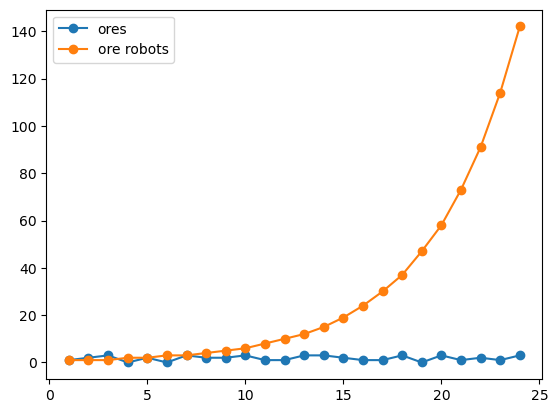

In [5]:
ts = np.arange(1, 25)

n_ore = 0
ores = []
robs = []
n_r_ore = 1
for t in ts:
    n_ore += n_r_ore
    if n_ore >= 4:
        n_r_ore += n_ore // 4
        n_ore -= 4 * (n_ore // 4)

    ores.append(n_ore)
    robs.append(n_r_ore)

robs = np.array(robs)
ores = np.array(ores)
plt.plot(ts, ores, 'o-', label="ores")
plt.plot(ts, robs, 'o-', label="ore robots")
plt.legend();


"ore robots" now shows how many ores robots can be available if all ores are used to build such robots.

We now assume that no ores are actually consumed for this purpose and see how many ores are then available at best at each point in time.

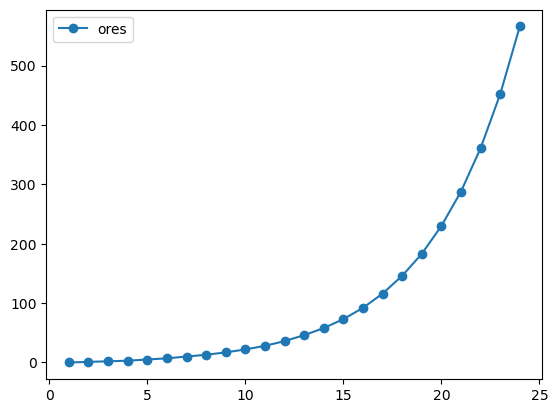

In [6]:
def produce(r, start=0):
    p = np.zeros_like(r)
    p[1:] = r.cumsum()[:-1] 
    return p + start

#ores = np.zeros_like(robs)
#ores[1:] = robs.cumsum()[:-1]
ores = produce(robs)

plt.plot(ts, ores, 'o-', label='ores')
plt.legend();

Now an estimate for the Clay Robots if we spend all the Ores on Clays.

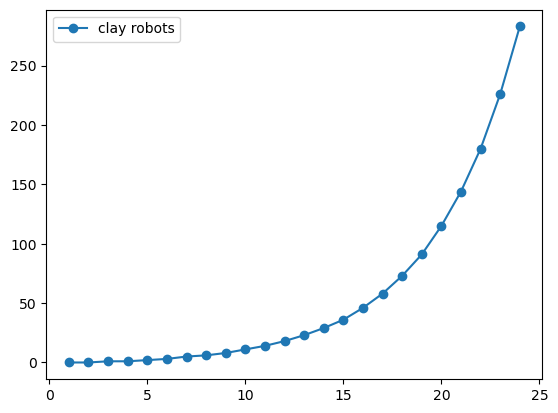

In [7]:
clay_robs = ores // 2
plt.plot(ts, clay_robs, 'o-', label='clay robots')
plt.legend();

Use this to estimate the production of the clays.

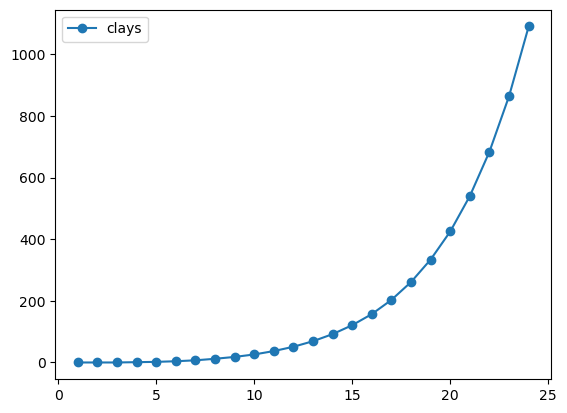

In [8]:
#clays = clay_robs.cumsum()
clays = produce(clay_robs)
plt.plot(ts, clays, 'o-', label="clays")
plt.legend();

Now we want to build Obsidian Robots with the maximum Ores and Clays

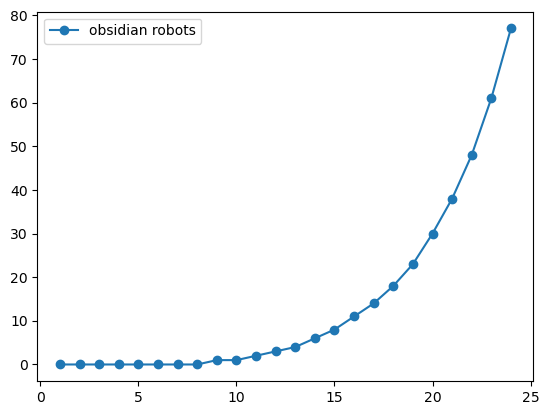

In [9]:
ob_robs = ores // 3
mask = clays // 14 < ores // 3
ob_robs[mask] = (clays // 14)[mask]
ores // 3, clays // 14, ob_robs

plt.plot(ts, ob_robs, 'o-', label='obsidian robots')
plt.legend();

Now the obsidian

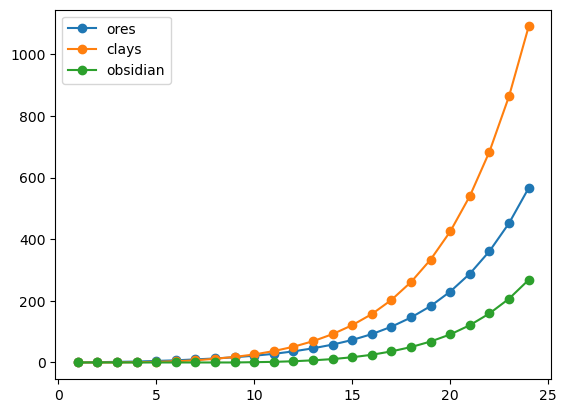

In [10]:
#obs = ob_robs.cumsum()
obs = produce(ob_robs)

plt.plot(ts, ores, 'o-', label='ores')
plt.plot(ts, clays, 'o-', label="clays")
plt.plot(ts, obs, "o-", label="obsidian")
plt.legend();

Now construct geode robots

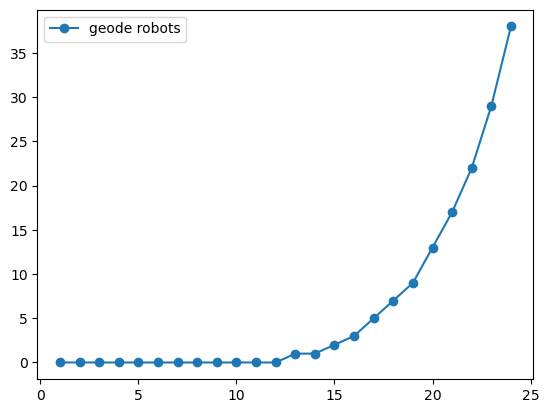

In [11]:
gd_robs = ores // 2
mask = obs // 7 < ores // 2
gd_robs[mask] = (obs // 7)[mask]

plt.plot(ts, gd_robs, 'o-', label='geode robots')
plt.legend();

How many open geodes?

109

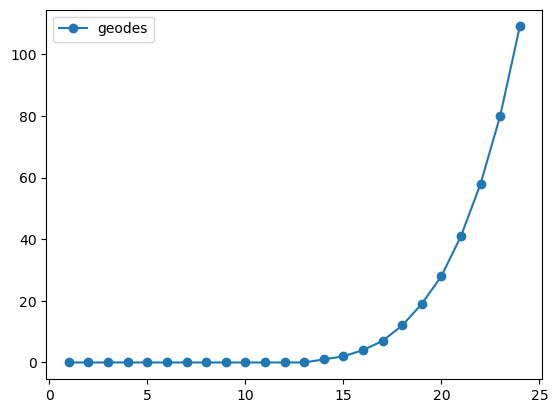

In [12]:
#gd = gd_robs.cumsum()
gd = produce(gd_robs)

plt.plot(ts, gd, 'o-', label='geodes')
plt.legend()
max(gd)

Now putting it all in one function to get an upper limit for 
geodes produceable for the current state

In [13]:
def maximum_geodes(t_max, state):
    robots, material = state
    n_ore, n_clay, n_obs, n_geode = material
    n_ore_robs, n_clay_robs, n_obs_robs, n_geod_robs = robots

    # ores
    ores = []
    robs = []
    n_m_ore = n_ore
    n_r_ore = n_ore_robs
    for t in range(1, t_max):
        n_m_ore += n_r_ore
        if n_m_ore >= 4:
            n_r_ore += n_m_ore // 4
            n_m_ore -= 4 * (n_m_ore // 4)

        ores.append(n_m_ore)
        robs.append(n_r_ore)

    robs = np.array(robs)
    ores = np.array(ores)

    ores = produce(robs, n_ore)

    # clays
    clay_robs = n_clay_robs + ores // 2
    clays = produce(clay_robs, n_clay)

    # obsidian
    ob_robs = ores // 3
    mask = clays // 14 < ores // 3
    ob_robs[mask] = (clays // 14)[mask]   
    ob_robs += n_obs_robs 
    obs = produce(ob_robs, n_obs)

    # geodes
    gd_robs = ores // 2
    mask = obs // 7 < ores // 2
    gd_robs[mask] = (obs // 7)[mask]    
    gd_robs += n_geod_robs
    gd = produce(gd_robs, n_geode)

    return max(gd)


In [14]:
state0 = (np.array((1, 0, 0, 0)), np.array((0, 0, 0, 0)))
maximum_geodes(25, state0)

109

In [17]:
# r_ore, r_clay, r_obs, r_geode 
robots = np.array((1, 0, 0, 0))

# n_ore, n_clay, n_obs, n_opg
material = np.array((0, 0, 0, 0))
states = [(robots, material)] # starting position. We only have one possible state

for t in range(1, 10):
    new_states = []
    for robots, material in states:
        material += robots
        # add the "do-nothing" state for later
        new_states.append((robots, material))
        for i, b in enumerate(blueprint):
            m = np.array(material) - b
            if all(m >= 0):
                print(t, ": can build robot", i)
                r = np.array(robots)
                r[i] += 1
                new_states.append((r, m))
    states = new_states

    

2 : can build robot 1
3 : can build robot 1
4 : can build robot 0
4 : can build robot 1
4 : can build robot 1
4 : can build robot 1
5 : can build robot 0
5 : can build robot 1
5 : can build robot 1
5 : can build robot 1
5 : can build robot 1
5 : can build robot 1
6 : can build robot 0
6 : can build robot 1
6 : can build robot 1
6 : can build robot 0
6 : can build robot 1
6 : can build robot 0
6 : can build robot 1
6 : can build robot 1
6 : can build robot 0
6 : can build robot 1
6 : can build robot 1
6 : can build robot 0
6 : can build robot 1
6 : can build robot 1
6 : can build robot 1
6 : can build robot 0
6 : can build robot 1
6 : can build robot 1
6 : can build robot 1
7 : can build robot 0
7 : can build robot 1
7 : can build robot 0
7 : can build robot 1
7 : can build robot 0
7 : can build robot 1
7 : can build robot 0
7 : can build robot 1
7 : can build robot 1
7 : can build robot 0
7 : can build robot 1
7 : can build robot 1
7 : can build robot 1
7 : can build robot 0
7 : can bu

In [18]:
states

[(array([1, 0, 0, 0]), array([9, 0, 0, 0])),
 (array([2, 0, 0, 0]), array([5, 0, 0, 0])),
 (array([1, 1, 0, 0]), array([7, 0, 0, 0])),
 (array([2, 0, 0, 0]), array([6, 0, 0, 0])),
 (array([3, 0, 0, 0]), array([2, 0, 0, 0])),
 (array([2, 1, 0, 0]), array([4, 0, 0, 0])),
 (array([1, 1, 0, 0]), array([7, 1, 0, 0])),
 (array([2, 1, 0, 0]), array([3, 1, 0, 0])),
 (array([1, 2, 0, 0]), array([5, 1, 0, 0])),
 (array([2, 0, 0, 0]), array([7, 0, 0, 0])),
 (array([3, 0, 0, 0]), array([3, 0, 0, 0])),
 (array([2, 1, 0, 0]), array([5, 0, 0, 0])),
 (array([3, 0, 0, 0]), array([4, 0, 0, 0])),
 (array([4, 0, 0, 0]), array([0, 0, 0, 0])),
 (array([3, 1, 0, 0]), array([2, 0, 0, 0])),
 (array([2, 1, 0, 0]), array([5, 1, 0, 0])),
 (array([3, 1, 0, 0]), array([1, 1, 0, 0])),
 (array([2, 2, 0, 0]), array([3, 1, 0, 0])),
 (array([1, 1, 0, 0]), array([7, 2, 0, 0])),
 (array([2, 1, 0, 0]), array([3, 2, 0, 0])),
 (array([1, 2, 0, 0]), array([5, 2, 0, 0])),
 (array([2, 1, 0, 0]), array([4, 2, 0, 0])),
 (array([3

Using blueprint 2 we have after minute 3 these possible states:

```
[(array([1, 0, 0, 0]), array([3, 0, 0, 0])),
 (array([1, 1, 0, 0]), array([1, 0, 0, 0])),
 (array([1, 1, 0, 0]), array([1, 1, 0, 0]))]
```

Obviously the 2nd row is worse than the 3rd row. We will prune the
possibilities for the same collection of robots.

In [19]:
def prune(states):
    s = defaultdict(list)
    for robots, material in states:
        s[tuple(robots)].append(material)

    res = []
    for k, v in s.items():
        if len(v) == 1:
            res.append((np.array(k), v[0]))
        else:
            # not very efficient, but I hope v will be small...
            mi = list(enumerate(v))
            bad = []
            for a, b in permutations(mi, 2):
                i, ma = a
                j, mb = b
                if all(ma >= mb):
                    bad.append(j)
            for i, m in mi:
                if i not in bad:
                    res.append((np.array(k), m))
    return res

In [20]:
prune(states)

[(array([1, 0, 0, 0]), array([9, 0, 0, 0])),
 (array([2, 0, 0, 0]), array([10,  0,  0,  0])),
 (array([1, 1, 0, 0]), array([7, 7, 0, 0])),
 (array([3, 0, 0, 0]), array([9, 0, 0, 0])),
 (array([2, 1, 0, 0]), array([8, 4, 0, 0])),
 (array([2, 1, 0, 0]), array([6, 7, 0, 0])),
 (array([1, 2, 0, 0]), array([ 5, 12,  0,  0])),
 (array([4, 0, 0, 0]), array([6, 0, 0, 0])),
 (array([3, 1, 0, 0]), array([7, 2, 0, 0])),
 (array([3, 1, 0, 0]), array([6, 4, 0, 0])),
 (array([3, 1, 0, 0]), array([3, 7, 0, 0])),
 (array([2, 2, 0, 0]), array([6, 7, 0, 0])),
 (array([2, 2, 0, 0]), array([4, 9, 0, 0])),
 (array([2, 2, 0, 0]), array([ 2, 12,  0,  0])),
 (array([1, 3, 0, 0]), array([ 3, 15,  0,  0])),
 (array([4, 1, 0, 0]), array([4, 2, 0, 0])),
 (array([4, 1, 0, 0]), array([2, 4, 0, 0])),
 (array([3, 2, 0, 0]), array([5, 3, 0, 0])),
 (array([3, 2, 0, 0]), array([4, 5, 0, 0])),
 (array([3, 2, 0, 0]), array([3, 7, 0, 0])),
 (array([3, 2, 0, 0]), array([0, 9, 0, 0])),
 (array([2, 3, 0, 0]), array([4, 9, 0, 

Putting the time step together with the pruning we get:
(I will also put the material production *after* the robot creation
to mimick the example)

In [88]:
def run(t_max, blueprint):
    # r_ore, r_clay, r_obs, r_geode 
    robots = np.array((1, 0, 0, 0))     # starting position

    # n_ore, n_clay, n_obs, n_opg
    material = np.array((0, 0, 0, 0))   # starting material

    states = [(robots, material)] # starting position. We only have one possible state
    return run_states(states, t_max)

def run_states(states, dt):
    for t in range(0, dt):
        new_states = []
        for robots, material in states:
            #material += robots
            # add the "do-nothing" state for later
            if True:#material[0] < max_ore_waiting:
                new_states.append((robots, material + robots))
            # robot production
            for i, b in enumerate(blueprint):
                m = np.array(material) - b
                if all(m >= 0):
                    r = np.array(robots)
                    r[i] += 1
                    # material prodcution with old robot population
                    new_states.append((r, m + robots))
        # pruning 1
        states = prune(new_states)
        # pruning 2
        current_best = max(m[-1] for _,m in states)
        if t < 23:
            states = [s for s in states if maximum_geodes(25 - t, s) >= current_best]
    
    return states

With pruning we run 13.3s:

In [89]:
t = 24
states = run(t, blueprint)
len(states)

2887

Without pruning 1m43s:

In [85]:
t = 24
states = run(t, blueprint)
len(states)

116181

Not that much of a difference. Maybe there could be a more aggressive pruning?

## A solution for different blueprints

In [94]:
def maximum_geodes(t_max, state, blueprint):
    ore_bp, clay_bp, obs_bp, geode_bp = blueprint
    robots, material = state
    n_ore, n_clay, n_obs, n_geode = material
    n_ore_robs, n_clay_robs, n_obs_robs, n_geod_robs = robots

    # ores
    ores = []
    robs = []
    n_m_ore = n_ore
    n_r_ore = n_ore_robs
    for t in range(1, t_max):
        n_m_ore += n_r_ore
        if n_m_ore >= ore_bp[0]:
            n_r_ore += n_m_ore // ore_bp[0]
            n_m_ore -= ore_bp[0] * (n_m_ore // ore_bp[0])

        ores.append(n_m_ore)
        robs.append(n_r_ore)

    robs = np.array(robs)
    ores = np.array(ores)

    ores = produce(robs, n_ore)

    # clays
    clay_robs = n_clay_robs + ores // clay_bp[0]
    clays = produce(clay_robs, n_clay)

    # obsidian
    ob_robs = ores // obs_bp[0]
    mask = clays // obs_bp[1] < ores // obs_bp[0]
    ob_robs[mask] = (clays // obs_bp[0])[mask]   
    ob_robs += n_obs_robs 
    obs = produce(ob_robs, n_obs)

    # geodes
    gd_robs = ores // geode_bp[0]
    mask = obs // geode_bp[2] < ores // geode_bp[0]
    gd_robs[mask] = (obs // geode_bp[2])[mask]    
    gd_robs += n_geod_robs
    gd = produce(gd_robs, n_geode)

    return max(gd)

In [181]:
def run(blueprint, t_max=24, max_geod=0):
    # r_ore, r_clay, r_obs, r_geode 
    robots = np.array((1, 0, 0, 0))     # starting position

    # n_ore, n_clay, n_obs, n_opg
    material = np.array((0, 0, 0, 0))   # starting material

    states = [(robots, material)] # starting position. We only have one possible state
    return run_states(states, t_max, blueprint, max_geod)

def run_states(states, dt, blueprint, max_geod):
    for t in range(0, dt):
        new_states = []
        for robots, material in states:
            #material += robots
            # add the "do-nothing" state for later
            if True:#material[0] < max_ore_waiting:
                new_states.append((robots, material + robots))
            # robot production
            for i, b in enumerate(blueprint):
                m = np.array(material) - b
                if all(m >= 0):
                    r = np.array(robots)
                    r[i] += 1
                    # material prodcution with old robot population
                    new_states.append((r, m + robots))
        # pruning 1
        states = prune(new_states)
        # pruning 2
        current_best = max(m[-1] for _,m in states)
        if current_best > max_geod:
            print("new best value ", current_best, " at t=", t)
            max_geod = current_best
        #if 18 < t:  # values thru experimentation
        if current_best > 0:
            surely_keep = [(r, m) for r, m in states if m[-1] == current_best]
            other = [(r, m) for r, m in states if m[-1] != current_best]
            after_states = [s for s in other if maximum_geodes(25 - t, s, blueprint) >= max_geod]
            diff = len(other) - len(after_states) 
            if diff > 0:
                print("Dropped ", diff, " states of", len(states), " at t=", t)
            states = surely_keep + after_states
    
    return states, current_best, max_geod

In [183]:
states, current_best, max_geod = run(blueprint, max_geod=12)

Dropped  253  states of 3828  at t= 18
Dropped  2386  states of 6824  at t= 19
Dropped  9478  states of 9788  at t= 20
Dropped  1003  states of 1006  at t= 21


In [184]:
max_geod

12

In [186]:
for s in states:
    _, m = s
    if m[-1] == max_geod:
        print(s)

In [187]:
blueprint2 = np.array([
    (2, 0, 0, 0),   # to make ore robot
    (3, 0, 0, 0),   # to make clay robot
    (3, 8, 0, 0),  # to make obsidian robot
    (3, 0, 12, 0)    # to make geode robot
])

In [188]:
states, current_best, max_geod = run(blueprint2, max_geod=max_geod)

Dropped  665  states of 17521  at t= 18
Dropped  13709  states of 32892  at t= 19
Dropped  36275  states of 42238  at t= 20
Dropped  14610  states of 15451  at t= 21
Dropped  2332  states of 2730  at t= 22
Dropped  1040  states of 1362  at t= 23


### Now let's read in the blueprints!

In [232]:
def read_input(file_name):
    bps = []
    with open(file_name) as f:
        for line in f.readlines():
            print()
            line = line.strip()
            if line == '':
                continue
            ore, clay, obs, geode = [p.split("costs")[1].split("ore") for p in line.split("Each")[1:]]
            ore = (int(ore[0]), 0, 0, 0)
            clay = (int(clay[0]), 0, 0, 0)
            obs = (int(obs[0]), int(obs[1].split()[1]), 0, 0)
            geode = (int(geode[0]), 0, int(geode[1].split()[1]), 0)
            bps.append(np.array([ore, clay, obs, geode]))
    return bps            


In [ ]:
bps = read_input("input")

In [236]:
bps

[array([[ 4,  0,  0,  0],
        [ 4,  0,  0,  0],
        [ 2, 11,  0,  0],
        [ 4,  0,  8,  0]]),
 array([[ 4,  0,  0,  0],
        [ 4,  0,  0,  0],
        [ 2, 16,  0,  0],
        [ 4,  0, 16,  0]]),
 array([[ 3,  0,  0,  0],
        [ 4,  0,  0,  0],
        [ 4, 18,  0,  0],
        [ 2,  0, 11,  0]]),
 array([[ 2,  0,  0,  0],
        [ 2,  0,  0,  0],
        [ 2, 17,  0,  0],
        [ 2,  0, 10,  0]]),
 array([[ 4,  0,  0,  0],
        [ 3,  0,  0,  0],
        [ 2, 10,  0,  0],
        [ 4,  0, 10,  0]]),
 array([[ 2,  0,  0,  0],
        [ 3,  0,  0,  0],
        [ 3,  8,  0,  0],
        [ 3,  0, 20,  0]]),
 array([[ 3,  0,  0,  0],
        [ 3,  0,  0,  0],
        [ 2, 20,  0,  0],
        [ 2,  0, 20,  0]]),
 array([[ 3,  0,  0,  0],
        [ 4,  0,  0,  0],
        [ 3,  6,  0,  0],
        [ 2,  0, 10,  0]]),
 array([[ 3,  0,  0,  0],
        [ 4,  0,  0,  0],
        [ 4,  6,  0,  0],
        [ 3,  0, 16,  0]]),
 array([[ 4,  0,  0,  0],
        [ 3,  0,  0,

In [237]:
max_geod = 0
qualities = []
for i, bp in enumerate(bps):
    print("Running blueprint ", i+1)
    print("Curren max_geod is ", max_geod)
    print(bp)
    states, current_best, max_geod = run(bp, max_geod=0)
    qualities.append((i+1, current_best))
    print("current_best ", current_best)
    print()

Running blueprint  1
Curren max_geod is  0
[[ 4  0  0  0]
 [ 4  0  0  0]
 [ 2 11  0  0]
 [ 4  0  8  0]]
new best value  1  at t= 21
Dropped  478  states of 5057  at t= 21
new best value  2  at t= 22
Dropped  8578  states of 8886  at t= 22
new best value  3  at t= 23
Dropped  667  states of 669  at t= 23
current_best  3

Running blueprint  2
Curren max_geod is  3
[[ 4  0  0  0]
 [ 4  0  0  0]
 [ 2 16  0  0]
 [ 4  0 16  0]]
current_best  0

Running blueprint  3
Curren max_geod is  0
[[ 3  0  0  0]
 [ 4  0  0  0]
 [ 4 18  0  0]
 [ 2  0 11  0]]
new best value  1  at t= 23
Dropped  18494  states of 18576  at t= 23
current_best  1

Running blueprint  4
Curren max_geod is  1
[[ 2  0  0  0]
 [ 2  0  0  0]
 [ 2 17  0  0]
 [ 2  0 10  0]]
new best value  1  at t= 19
Dropped  1  states of 20036  at t= 19
new best value  2  at t= 20
Dropped  132  states of 36550  at t= 20
new best value  4  at t= 21
Dropped  19122  states of 68203  at t= 21
new best value  6  at t= 22
Dropped  95286  states of 1037

In [238]:
qualities

[(1, 3),
 (2, 0),
 (3, 1),
 (4, 9),
 (5, 5),
 (6, 6),
 (7, 0),
 (8, 9),
 (9, 5),
 (10, 0),
 (11, 12),
 (12, 0),
 (13, 10),
 (14, 0),
 (15, 4),
 (16, 0),
 (17, 1),
 (18, 3),
 (19, 4),
 (20, 0),
 (21, 3),
 (22, 3),
 (23, 2),
 (24, 0),
 (25, 1),
 (26, 0),
 (27, 0),
 (28, 13),
 (29, 0),
 (30, 15)]

In [239]:
prods = [x*y for x, y in qualities]


In [241]:
sum(prods)

1703

Part 1 took approx 15 min

# Part 2

In [242]:
blueprint = np.array([
    (4, 0, 0, 0),   # to make ore robot
    (2, 0, 0, 0),   # to make clay robot
    (3, 14, 0, 0),  # to make obsidian robot
    (2, 0, 7, 0)    # to make geode robot
])

In [292]:
def maximum_geodes(t_max, state, blueprint):
    ore_bp, clay_bp, obs_bp, geode_bp = blueprint
    robots, material = state
    n_ore, n_clay, n_obs, n_geode = material
    n_ore_robs, n_clay_robs, n_obs_robs, n_geod_robs = robots

    # ores
    ores = []
    robs = []
    n_m_ore = n_ore
    n_r_ore = n_ore_robs
    for t in range(1, t_max):
        n_m_ore += n_r_ore
        if n_m_ore >= ore_bp[0]:
            n_r_ore += n_m_ore // ore_bp[0]
            n_m_ore -= ore_bp[0] * (n_m_ore // ore_bp[0])

        ores.append(n_m_ore)
        robs.append(n_r_ore)

    robs = np.array(robs)
    ores = np.array(ores)

    ores = produce(robs, n_ore)

    # clays
    clay_robs = n_clay_robs + ores // clay_bp[0]
    clays = produce(clay_robs, n_clay)

    # obsidian
    ob_robs = ores // obs_bp[0]
    mask = clays // obs_bp[1] < ores // obs_bp[0]
    ob_robs[mask] = (clays // obs_bp[0])[mask]   
    ob_robs += n_obs_robs 
    obs = produce(ob_robs, n_obs)

    # geodes
    gd_robs = ores // geode_bp[0]
    mask = obs // geode_bp[2] < ores // geode_bp[0]
    gd_robs[mask] = (obs // geode_bp[2])[mask]    
    gd_robs += n_geod_robs
    gd = produce(gd_robs, n_geode)

    return max(gd)

In [293]:
state0 = (np.array((1, 0, 0, 0)), np.array((0, 0, 0, 0)))
maximum_geodes(24, state0, blueprint)

434

In [319]:
def run(blueprint, t_max=24, max_geod=0):
    # r_ore, r_clay, r_obs, r_geode 
    robots = np.array((1, 0, 0, 0))     # starting position

    # n_ore, n_clay, n_obs, n_opg
    material = np.array((0, 0, 0, 0))   # starting material

    states = [(robots, material)] # starting position. We only have one possible state
    return run_states(states, t_max, blueprint)

def run_states(states, t_max, blueprint):
    for t in range(0, t_max):
        new_states = []
        for robots, material in states:
            #material += robots
            # add the "do-nothing" state for later
            if True:#material[0] < max_ore_waiting:
                new_states.append((robots, material + robots))
            # robot production
            for i, b in enumerate(blueprint):
                m = np.array(material) - b
                if all(m >= 0):
                    r = np.array(robots)
                    r[i] += 1
                    # material prodcution with old robot population
                    new_states.append((r, m + robots))
        # pruning 1
        states = prune(new_states)
        # pruning 2
        found_geods = [(r,m) for r,m in states if m[-1] > 0]
        if found_geods:
            current_best = max(m[-1] + r[-1]*(t_max - t) for r,m in found_geods)
            #current_best = max(m[-1] for r,m in found_geods)
        else:
            current_best = 0
        #if 18 < t:  # values thru experimentation
        if current_best > 0 and t + 1 != t_max:
            surely_keep = [(r, m) for r, m in states if m[-1] + r[-1]*(t_max - t) == current_best]
            other = [(r, m) for r, m in states if  m[-1] + r[-1]*(t_max - t) != current_best]
            after_states = [s for s in other if maximum_geodes(t_max - t, s, blueprint) >= current_best]
            diff = len(other) - len(after_states) 
            if diff > 0:
                print("Dropped ", diff, " states of", len(states), " at t=", t)
            states = surely_keep + after_states
    
    return states, current_best, max(m[-1] for _, m in states)

In [320]:
run(blueprint, t_max=24)

Dropped  531  states of 3828  at t= 18
Dropped  3563  states of 6475  at t= 19
Dropped  6818  states of 6820  at t= 20


([(array([1, 4, 2, 2]), array([ 6, 41,  8,  9])),
  (array([2, 4, 2, 2]), array([ 3, 41,  8,  9])),
  (array([1, 5, 2, 2]), array([ 4, 46,  8,  9])),
  (array([1, 4, 3, 2]), array([ 3, 27, 10,  9])),
  (array([1, 6, 2, 2]), array([ 2, 47,  8,  9])),
  (array([1, 5, 3, 2]), array([ 1, 32,  8,  9])),
  (array([1, 5, 3, 2]), array([ 1, 27, 10,  9])),
  (array([1, 4, 3, 3]), array([ 1, 27,  3,  9]))],
 12,
 9)

In [296]:
blueprint

array([[ 4,  0,  0,  0],
       [ 2,  0,  0,  0],
       [ 3, 14,  0,  0],
       [ 2,  0,  7,  0]])

In [299]:
run(blueprint, t_max=32)

new best value  15  at t= 18
new best value  27  at t= 20
Dropped  10  states of 13857  at t= 20
Dropped  25  states of 27417  at t= 21
new best value  35  at t= 22
Dropped  276  states of 56221  at t= 22
new best value  43  at t= 23
Dropped  1754  states of 115672  at t= 23
Dropped  5290  states of 233913  at t= 24
new best value  50  at t= 25
Dropped  77986  states of 465068  at t= 25
new best value  56  at t= 26
Dropped  772761  states of 799069  at t= 26
Dropped  71036  states of 71041  at t= 27
new best value  60  at t= 28
Dropped  11  states of 16  at t= 28
new best value  63  at t= 29
Dropped  12  states of 17  at t= 29
new best value  65  at t= 30
Dropped  13  states of 18  at t= 30
new best value  66  at t= 31


([(array([2, 7, 5, 9]), array([ 8, 84, 10, 56])),
  (array([3, 7, 5, 9]), array([ 8, 84, 10, 56])),
  (array([2, 8, 5, 9]), array([ 6, 91, 10, 56])),
  (array([2, 7, 6, 9]), array([ 5, 70, 14, 56])),
  (array([4, 7, 5, 9]), array([ 4, 84, 10, 56])),
  (array([3, 8, 5, 9]), array([ 6, 84, 10, 56])),
  (array([3, 8, 5, 9]), array([ 2, 91, 10, 56])),
  (array([3, 7, 6, 9]), array([ 5, 70, 10, 56])),
  (array([2, 9, 5, 9]), array([ 4, 95, 10, 56])),
  (array([2, 8, 6, 9]), array([ 3, 77, 10, 56])),
  (array([2, 8, 6, 9]), array([ 3, 70, 14, 56])),
  (array([2, 7, 7, 9]), array([ 2, 56, 14, 56])),
  (array([ 2,  7,  6, 10]), array([ 3, 70,  7, 56])),
  (array([ 2, 10,  5,  9]), array([ 2, 95, 10, 56]))],
 66,
 66)

OK, 77m. Not ideal, but we can do this for three blueprints!

In [303]:
max_geod = 0
qualities = []
for i, bp in enumerate(bps[:3]):
    print("Running blueprint ", i+1)
    print("Curren max_geod is ", max_geod)
    print(bp)
    states, current_best, max_geod = run(bp, t_max=32)
    qualities.append((i+1, current_best))
    print("current_best ", current_best)
    print()

Running blueprint  1
Curren max_geod is  0
[[ 4  0  0  0]
 [ 4  0  0  0]
 [ 2 11  0  0]
 [ 4  0  8  0]]
new best value  12  at t= 21
Dropped  8  states of 9446  at t= 22
new best value  20  at t= 23
Dropped  15  states of 18055  at t= 23
Dropped  70  states of 35744  at t= 24
new best value  27  at t= 25
Dropped  1708  states of 72590  at t= 25
Dropped  31059  states of 147977  at t= 26
new best value  32  at t= 27
Dropped  248886  states of 252813  at t= 27
new best value  34  at t= 28
Dropped  11002  states of 11025  at t= 28
new best value  36  at t= 30
Dropped  197  states of 267  at t= 30
new best value  37  at t= 31
current_best  37

Running blueprint  2
Curren max_geod is  37
[[ 4  0  0  0]
 [ 4  0  0  0]
 [ 2 16  0  0]
 [ 4  0 16  0]]
new best value  7  at t= 26
Dropped  1862  states of 38972  at t= 26
Dropped  23699  states of 65609  at t= 27
new best value  11  at t= 28
Dropped  81929  states of 81932  at t= 28
new best value  12  at t= 31
current_best  12

Running blueprint 

In [304]:
qualities

[(1, 37), (2, 12), (3, 24)]

In [305]:
37*12*24

10656

In [321]:
max_geod = 0
qualities = []
all_states = []
for i, bp in enumerate(bps[:3]):
    print("Running blueprint ", i+1)
    print("Curren max_geod is ", max_geod)
    print(bp)
    states, current_best, max_geode = run(bp, t_max=32)
    all_states.append(states)
    qualities.append((i+1, max_geode))
    print("current_best ", max_geode)
    print()

Running blueprint  1
Curren max_geod is  0
[[ 4  0  0  0]
 [ 4  0  0  0]
 [ 2 11  0  0]
 [ 4  0  8  0]]
Dropped  8  states of 9446  at t= 22
Dropped  15  states of 18055  at t= 23
Dropped  70  states of 35744  at t= 24
Dropped  1708  states of 72590  at t= 25
Dropped  31059  states of 147977  at t= 26
Dropped  248886  states of 252813  at t= 27
Dropped  11002  states of 11025  at t= 28
Dropped  197  states of 267  at t= 30
current_best  30

Running blueprint  2
Curren max_geod is  0
[[ 4  0  0  0]
 [ 4  0  0  0]
 [ 2 16  0  0]
 [ 4  0 16  0]]
Dropped  1862  states of 38972  at t= 26
Dropped  23699  states of 65609  at t= 27
Dropped  81929  states of 81932  at t= 28
current_best  9

Running blueprint  3
Curren max_geod is  0
[[ 3  0  0  0]
 [ 4  0  0  0]
 [ 4 18  0  0]
 [ 2  0 11  0]]
Dropped  7  states of 18576  at t= 23
Dropped  61  states of 32884  at t= 24
Dropped  4870  states of 59423  at t= 25
Dropped  48782  states of 105805  at t= 26
Dropped  125712  states of 125894  at t= 27


In [307]:
from numpy import array

In [324]:
def run(blueprint, t_max=24, max_geod=0):
    # r_ore, r_clay, r_obs, r_geode 
    robots = np.array((1, 0, 0, 0))     # starting position

    # n_ore, n_clay, n_obs, n_opg
    material = np.array((0, 0, 0, 0))   # starting material

    states = [(robots, material)] # starting position. We only have one possible state
    return run_states(states, t_max, blueprint)

def run_states(states, t_max, blueprint):
    current_best = 0
    for t in range(0, t_max):
        new_states = []
        for robots, material in states:
            #material += robots
            # add the "do-nothing" state for later
            if True:#material[0] < max_ore_waiting:
                new_states.append((robots, material + robots))
            # robot production
            for i, b in enumerate(blueprint):
                m = np.array(material) - b
                if all(m >= 0):
                    r = np.array(robots)
                    r[i] += 1
                    # material prodcution with old robot population
                    new_states.append((r, m + robots))
        # pruning 1
        states = prune(new_states)
        # pruning 2
        found_geods = [(r,m) for r,m in states if m[-1] > 0]
        if found_geods:
            current_best = max(m[-1] + r[-1]*max(0, (t_max - t - 1)) for r,m in found_geods)

        #if 18 < t:  # values thru experimentation
        if current_best > 0 and t + 1 != t_max:
            surely_keep = [(r, m) for r, m in states if m[-1] + r[-1]*max(0, (t_max - t - 1)) == current_best]
            other = [(r, m) for r, m in states if  m[-1] + r[-1]*max(0, (t_max - t - 1)) != current_best]
            after_states = [s for s in other if maximum_geodes(t_max - t, s, blueprint) >= current_best]
            diff = len(other) - len(after_states) 
            if diff > 0:
                print("Dropped ", diff, " states of", len(states), " at t=", t)
            states = surely_keep + after_states
    
    return states, current_best, max(m[-1] for _, m in states)

In [325]:
max_geod = 0
qualities = []
all_states = []
for i, bp in enumerate(bps[:3]):
    print("Running blueprint ", i+1)
    print("Curren max_geod is ", max_geod)
    print(bp)
    states, current_best, max_geode = run(bp, t_max=32)
    all_states.append(states)
    qualities.append((i+1, max_geode))
    print("current_best ", max_geode)
    print()

Running blueprint  1
Curren max_geod is  0
[[ 4  0  0  0]
 [ 4  0  0  0]
 [ 2 11  0  0]
 [ 4  0  8  0]]
Dropped  2  states of 9446  at t= 22
Dropped  13  states of 18054  at t= 23
Dropped  49  states of 35745  at t= 24
Dropped  914  states of 72608  at t= 25
Dropped  19000  states of 148994  at t= 26
Dropped  241903  states of 276715  at t= 27
Dropped  83736  states of 83737  at t= 28
Dropped  13  states of 17  at t= 30
current_best  31

Running blueprint  2
Curren max_geod is  0
[[ 4  0  0  0]
 [ 4  0  0  0]
 [ 2 16  0  0]
 [ 4  0 16  0]]
Dropped  1099  states of 38972  at t= 26
Dropped  16397  states of 66046  at t= 27
Dropped  92928  states of 93183  at t= 28
Dropped  885  states of 895  at t= 29
current_best  9

Running blueprint  3
Curren max_geod is  0
[[ 3  0  0  0]
 [ 4  0  0  0]
 [ 4 18  0  0]
 [ 2  0 11  0]]
Dropped  5  states of 18576  at t= 23
Dropped  42  states of 32887  at t= 24
Dropped  1852  states of 59447  at t= 25
Dropped  33281  states of 108602  at t= 26
Dropped  

In [326]:
qualities

[(1, 31), (2, 9), (3, 19)]

In [327]:
31*9*19

5301